In [1]:
# on MacOS
# ! brew install cmake
# ! pip install dlib
# ! pip install imutils

# on linux
# see 543's code

Camera Matrix :
 [[900.   0. 450.]
 [  0. 900. 603.]
 [  0.   0.   1.]]
Rotation Vector:
 [[-2.69979994]
 [ 0.10794173]
 [-0.38098336]]
Translation Vector:
 [[  405.97915432]
 [-1601.1969611 ]
 [ 4082.22187756]]


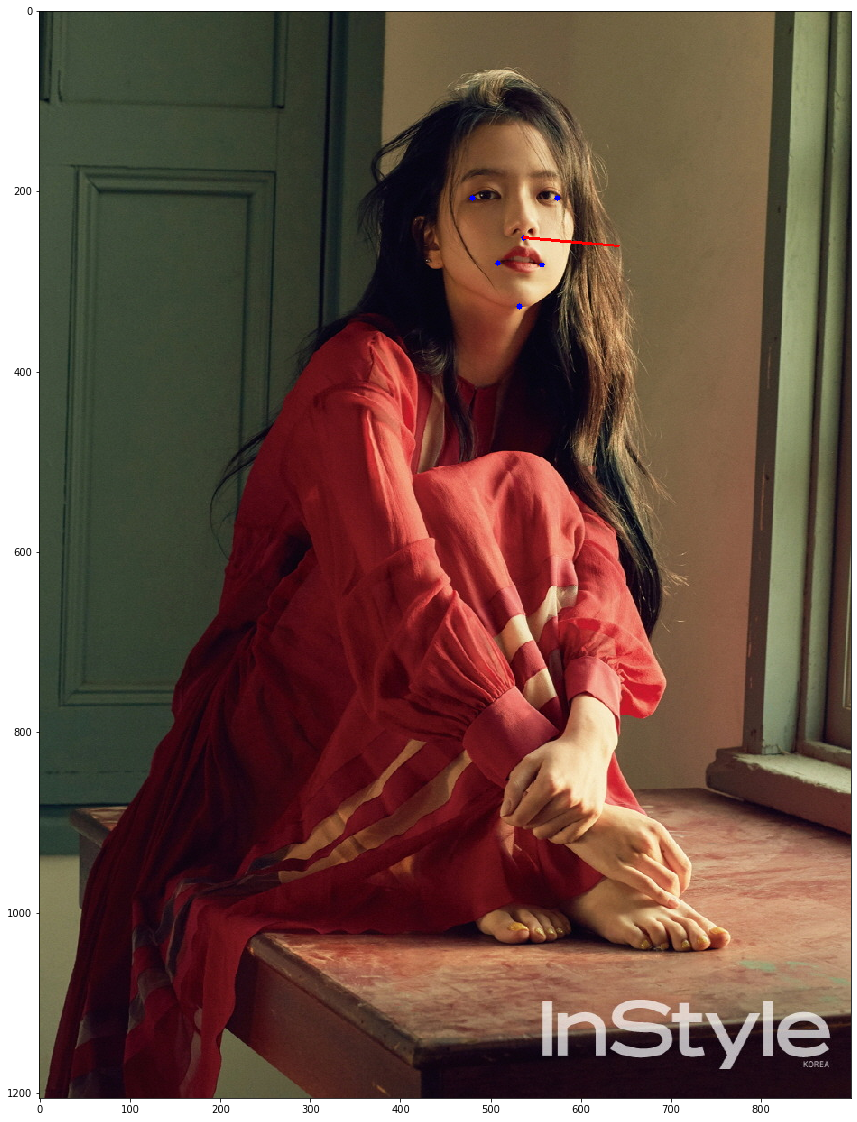

In [2]:
# reference: 
# https://github.com/chungbrain/Head-Pose-Estimation-using-OpenCV-and-Dlib/blob/master/FD_HD_part_6_measuring_test3.ipynb

import cv2
import numpy as np
import dlib
from imutils import face_utils

import matplotlib.pyplot as plt

# Read Image
im = cv2.imread("./Kim.Jisoo.full.172058.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

size = im.shape

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

gray  = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
# detect face
rects = detector(gray, 0)
for rect in rects:
    shape0 = predictor(gray, rect)
    shape0 = np.array(face_utils.shape_to_np(shape0))

#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (shape0[33, :]),     # Nose tip
                            (shape0[8,  :]),     # Chin
                            (shape0[36, :]),     # Left eye left corner
                            (shape0[45, :]),     # Right eye right corne
                            (shape0[48, :]),     # Left Mouth corner
                            (shape0[54, :])      # Right mouth corner
                        ], dtype="double")
 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corner
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                     
                        ])

# Camera intrinsics
focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
    [[focal_length, 0, center[0]],
    [0, focal_length, center[1]],
    [0, 0, 1]], dtype = "double"
)

print ("Camera Matrix :\n {0}".format(camera_matrix))

# TODO: mention this as future work in report
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(
    model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

print ("Rotation Vector:\n {0}".format(rotation_vector))
print ("Translation Vector:\n {0}".format(translation_vector))
 
# Project a 3D point (0, 0, 1000.0) onto the image plane.
# We use this to draw a line sticking out of the nose
(nose_end_point2D, jacobian) = cv2.projectPoints(
    np.array([(0.0, 0.0, 1000.0)]), 
    rotation_vector, translation_vector, 
    camera_matrix, dist_coeffs
)
 
# display purpose, circle out projected keypoints. 
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

# p1 -> p2 is normal direction.
p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(im, p1, p2, (255,0,0), 2) 
# Display image
plt.figure(figsize=(20, 20))
plt.imshow(im)

[[320 380]
 [320 560]
 [190 250]
 [450 250]
 [250 460]
 [390 460]]


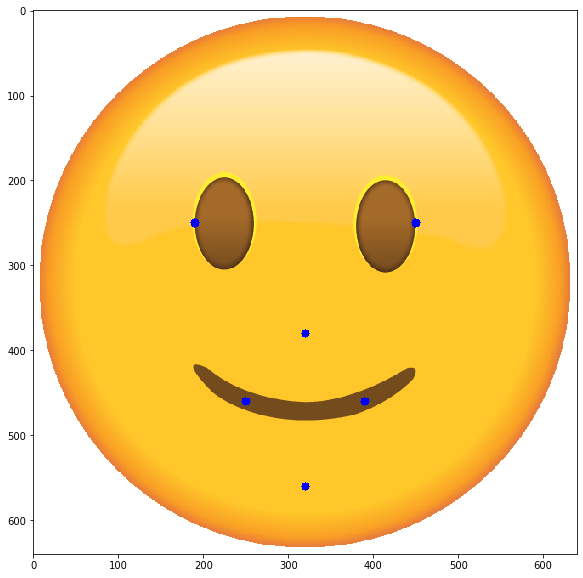

In [6]:
emoji = cv2.imread("./emojis/smile.png")
emoji = cv2.cvtColor(emoji, cv2.COLOR_BGR2RGB)

emoji_points = [
    (int(emoji.shape[0] / 2), 380), # nose
    (int(emoji.shape[0] / 2), 380 + 180), # chin
    (190, 250), # left eye
    (450, 250), # righteye
    (250, 460), # leftmouth
    (emoji.shape[0] - 250, 460) # rightmouth
]

for p in emoji_points:
    emoji = cv2.circle(emoji, p, 5, (0,0,255), -1)

emoji_points = np.array(emoji_points)
print(emoji_points)

plt.figure(figsize=(10, 10))
plt.imshow(emoji)

In [7]:
image_points = np.array([
                            (shape0[33, :]),     # Nose tip
                            (shape0[8,  :]),     # Chin
                            (shape0[36, :]),     # Left eye left corner
                            (shape0[45, :]),     # Right eye right corne
                            (shape0[48, :]),     # Left Mouth corner
                            (shape0[54, :])      # Right mouth corner
                        ], dtype="double")

homography, stats = cv2.findHomography(emoji_points, image_points)

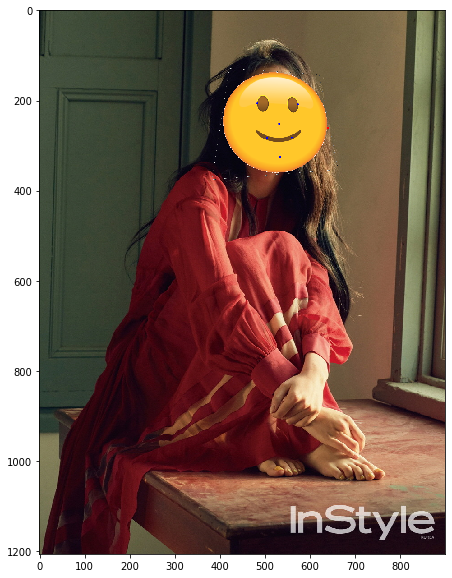

In [8]:
warped = cv2.warpPerspective(emoji, homography, (gray.shape[1], gray.shape[0]))
mask_white = (warped[:, :, 0:3] == [255,255,255]).all(2)
mask_black = (warped[:, :, 0:3] == [0., 0., 0.]).all(2)
mask_warped = np.logical_or(mask_white, mask_black)
mask_warped = np.stack([mask_warped] * 3, axis=2)
plt.figure(figsize=(10, 10))

plt.imshow(np.where(mask_warped, im, warped))